<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/generate_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inizializzation.

This Cell download and intstall ROOT in python 2 environment. 

Runs this part of the script only when you have to init a new machine e and working space

In [0]:
# sitallazione di ROOT dal CERN
!mkdir -p APPS
!pwd
!cd APPS && wget https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

# main paths for ROOT  
import sys
sys.path.append("/content/APPS/root/lib")
import ctypes
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf.so')
# itsllation and root-numpy main PATH
!pip install root-numpy
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMultiProc.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTreePlayer.so')
# patch to open online FILE
! sudo apt-get install libdavix0v5
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRDAVIX.so')
! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
! tail -1 $HOME/.rootrc

This Cell Load funcions (libraries) to retrive data from swift CYGNO server

Runs this part of the script only when you have to init a new machine e and working space

In [0]:
!pip install -q  python-swiftclient
!pip install -q  keystoneauth1
!pip install -q  h5py
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp
! rm cygnus_lib.*; rm mylib.*
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
sys.path.append('.')
import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

x_resolution = y_resolution = 2048
cy.set_atlas_style('square')
!mkdir -p data

Generate data stream file looking for close clusters in any images: 

1.   download pedestal file [run_ped]
2.   download dafa file/s [runI] from specifc location [dataSelection]
3.   Serch for cluster with DBSCAN
4.   save output in txt file


In [0]:
runI          = [1856] 
run_ped       = 1748 
cimax         = 300
cimin         = 0 
dataSelection = 'LAB'
rescale       = 512
nsigma        = 1.5

try:
  fh5 = ("run%d_mean.h5" % (run_ped))
  cmd = 'wget -nv https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
  fh5 = ("run%d_sigma.h5" % (run_ped))
  cmd = 'wget -nv https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
except:
  print ("No Pedestal file for run %s on remote repo" % run_ped)

#########################

try:
    fileoutm = ("./data/run%d_mean.h5" % (run_ped))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

    
try: 
    fileouts = ("./data/run%d_sigma.h5" % (run_ped))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

#########################

th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))
    
for nRi in range(0,len(runI)):
    try:
        print ('Open file: '+cy.swift_root_file(dataSelection, runI[nRi]))
        f = ROOT.TFile.Open(cy.swift_root_file(dataSelection, runI[nRi]))

        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        pic, wfm = cy.root_TH2_name(f)
        max_image = len(pic)
        max_wfm = len(wfm)
        print ("# of Images (TH2) Files: %d " % (max_image))
        print ("# of Waveform (TH2) Files: %d " % (max_wfm))
        nImag=max_image
    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break

    data_to_save = []
    files = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d_ped_%d.txt" % 
                     (runI[nRi], cimin, cimax, rescale, nsigma, max_image, run_ped))
    for iTr in range(0, max_image):
        if iTr % 10 == 0: # pach in order overcome the problem of ROOT memory garbage
             print ('Processing RUN: ', runI[nRi], 'Event: ', iTr)

        image = rtnp.hist2array(f.Get(pic[iTr])).T

        rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
        rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

        edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
        points          = np.array(np.nonzero(edges)).T.astype(float) 
        scaler          = StandardScaler()
        X_scaled        = scaler.fit_transform(points)

        dbscan          = DBSCAN(eps=4, min_samples = 30)
        dbscan.fit(points)

        clusters = dbscan.fit_predict(X_scaled)

        for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
            ph = 0.
            # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
            yc = points[:,1][dbscan.labels_==ic]
            xc = points[:,0][dbscan.labels_==ic]
            ph, dim = cy.cluster_par(yc, xc, rebin_image)
            width, height, pearson = cy.confidence_ellipse_par(yc,xc)
            for j in range(0, dim):
                x=int(xc[j])
                y=int(yc[j])
                #ph += rebin_image[y,x]
                if j == 0:
                    x0start = x
                    y0start = y
            x0end = x
            y0end = y
            data_to_save.append([iTr, ic, dim, ph, ph/dim, 
                                 x0start, y0start, x0end, y0end, width, height, pearson])

    np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
    print ("out file", files)

In [0]:
# outputs (.h5 are the pedestal files)
!ls data

da fare:
1.   studiarsi DBSCAN e come vengono selzionati i dati
2.   mostrare il risultato di cluserizzazione di DBSCAN su ogni imagine (fare un debug delo script mostrando le immagini)
2.   con panda caricare i file di output
2.   guardarsi le varie variabili, visualizzarli, capire che significano
3.   fare la distribuzione del numero di fotoni
4.   fittarla con un esponenziale (coda del fondo) piu' gaussina (picco dei fotoni)
5.   studiare l'andamento del picco del ferro nel tempo per i run pari tra 1856 e 2031





In [0]:
def TGraph2array(tgraph):
  xl = []; yl = []
  for i in range(tgraph.GetN()):
      xi = ctypes.c_double(); yi = ctypes.c_double()
      tgraph.GetPoint(i,xi,yi)
      xl.append(xi.value)
      yl.append(yi.value)
  x = np.array(xl)
  y = np.array(yl)
  return x, y

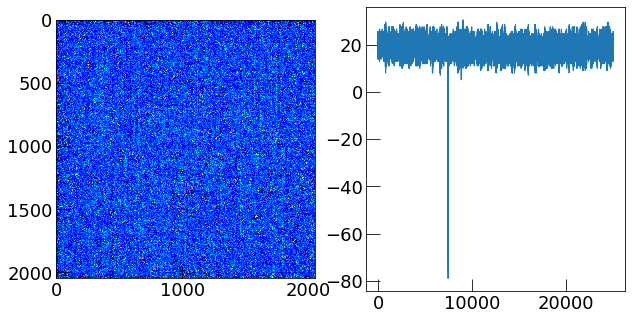

In [28]:
# mostra l'immagine iTr del file ...
fig, ax = plt.subplots (1,2, figsize=(10,5))
iTr = 0
#
f  = ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run01856.root');
pic, wfm = cy.root_TH2_name(f)
#
image = rtnp.hist2array(f.Get(pic[iTr])).T
t,a = TGraph2array(f.Get(wfm[iTr]))
ax[0].imshow(image,  cmap="jet", vmin=95,vmax=120)
ax[1].plot(x,y)
plt.show()